## Skoltech
## Intro to data science, fall 2025
## Assignment 2

### Goals
- Data investigation and visualization techniques
- Feature engineering and feature selection. GridSearch. Cross-validation
- Classification models 




## Dataset

This dataset concerns credit card applications. It has a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. General goal is to predict which people in the dataset are successful in applying for a credit card.

#### Attributes

-   Gender: 0=Female, 1=Male
-   Age: Age in years
-   Debt: Outstanding debt
-   Married: 0=Single/Divorced/etc, 1=Married
-   BankCustomer: 0=does not have a bank account, 1=has a bank account
-   Investment score: a number from 0 to 10
-   BankRecord
-   Industry: job sector of current or most recent job
-   Ethnicity
-   YearsEmployed
-   PriorDefault: 0=no prior defaults, 1=prior default
-   Employed: 0=not employed, 1=employed
-   CreditScore
-   DriversLicense: 0=no license, 1=has license
-   Citizenship: either ByBirth, ByOtherMeans or Temporary
-   ZipCode: 5 digit number
-   Income
-   Approved: 0=not approved, 1=approved

#### Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#### Read the data

In [2]:
df = pd.read_csv('credit_score_dataset.csv')

## 1. Data investigation and visualization

Let's take a closer look at the data.

In [3]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,InvestmentScore,BankRecord,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,3.65,1,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,1.94,1,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,8.15,1,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,7.99,1,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,2.37,1,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


### Q1.1

Calculate the 25th percentile (Q1) and 75th percentile (Q3) of the `CreditScore` for people who are married and not married. What is the interquartile range (IQR = Q3 - Q1) for both cases?

*Sample answer:* 5.870,0.101


In [4]:
perc_count = df.groupby("Married")["CreditScore"].agg(
    Q1 = lambda x: np.percentile(x, 25),
    Q3 = lambda x: np.percentile(x, 75)
)
perc_count["IQR"] = perc_count["Q3"] - perc_count["Q1"]
print(",".join([f"{value:.3f}" for value in sorted(perc_count["IQR"].values, reverse=True)]))

4.000,1.000


### Q1.2

#### People working in which industry have the lowest income on average? Report this income.
*Sample answer:* Energy,56.907

In [5]:
result = df.groupby("Industry")["Income"].mean().sort_values().head(1)
print("{},{:.3f}".format(result.index[0], result.iloc[0]))

Real Estate,111.267


### Q1.3

Build a [crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) for ethnicity and Industry. How many Asian people work in Energy?

In [6]:
df_crosstab = pd.crosstab(df["Industry"], df["Ethnicity"])
print(df_crosstab.loc["Energy", "Asian"])

14


### Q1.4

Let's assume that the column 'YearsEmployed' counts years from the first employment until the current moment. Given that, build a [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) for the age of the first employment. Don't forget to give your graph a title and name the axes.Make sure to run `plt.show()` to hide unnecessary service information. What is the median age of starting work? The answer must be a float.

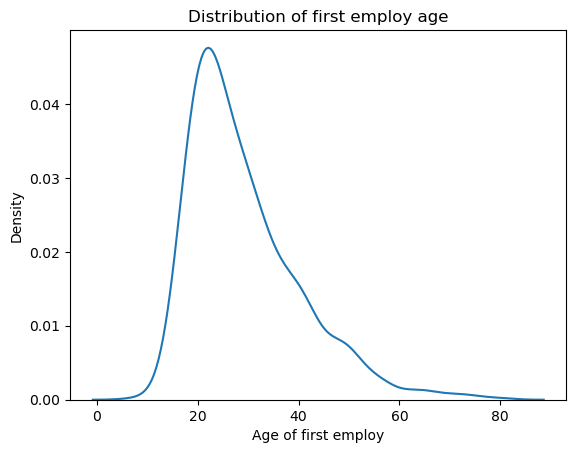

26.540


In [7]:
df["Employ_age"] = df["Age"] - df["YearsEmployed"]
sns.kdeplot(df["Employ_age"])
plt.title("Distribution of first employ age")
plt.xlabel("Age of first employ")
plt.ylabel("Density")
plt.show()
print("{:.3f}".format(df["Employ_age"].median()))

### Q1.5

Let's visualize the distribution of `Income`. Build a [boxenplot](https://seaborn.pydata.org/generated/seaborn.boxenplot.html) for this feature. Don't forget to give your graph a title ('Distribution of income') and name the y-axes ('Income'). Make sure to run `plt.show()` to hide unnecessary service information.

Do you notice anything strange? What are 3 maximal values of income? Write them **as integers in descending order**.
*Sample answer:* 30000,20000,10000

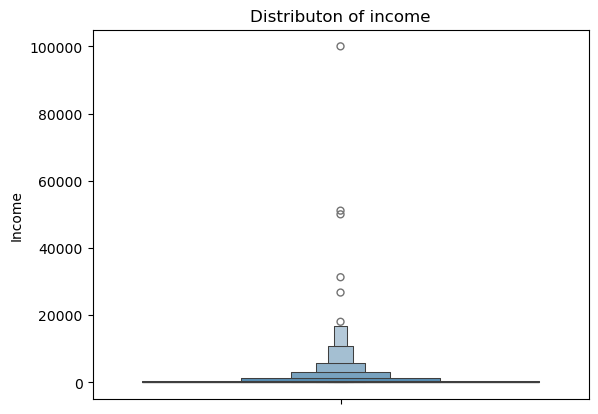

100000,51100,50000


In [8]:
sns.boxenplot(df["Income"])
plt.title("Distributon of income")
plt.ylabel("Income")
plt.show()
print(",".join([f"{value}" for value in df["Income"].sort_values(ascending=False).head(3)]))

### Q1.6

Outliers can affect the quality of machine learning algorithms, especially when the amount of data is insufficient. Drop all the values of `Income` above 15000 in the dataset. Plot the boxenplot for a new dataset (mind the requirements for the title, axis naming and `plt.show()`). What share of entries has been dropped? (the answer should be between $0$ and $1$).

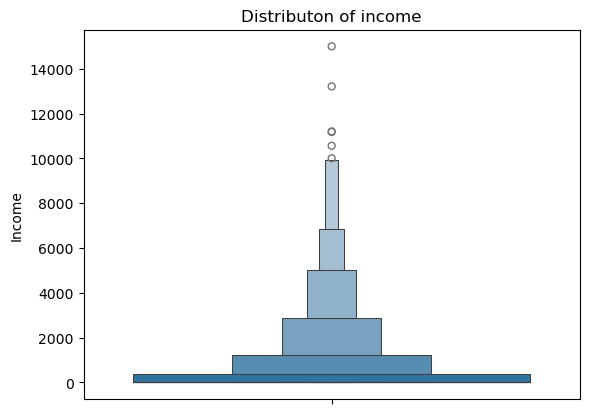

0.010


In [9]:
entries_before = df.shape[0]
df.drop(df.loc[df["Income"] > 15000].index, inplace=True)
entries_after = df.shape[0]
share = (entries_before - entries_after) / entries_before
sns.boxenplot(df["Income"])
plt.title("Distributon of income")
plt.ylabel("Income")
plt.show()
print(f"{share:.3f}")



### Q1.7

Plot [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html) for `Ethnicity` as x-axis, `Income` as y-axis and set `Married` as a `col`.

Validate the following hypothesis: **"Married people of all ethnicities, except for Others, have more income, than unmarried people of the same ethnicity".**
Your answer must be YES or NO without any additional symbols.

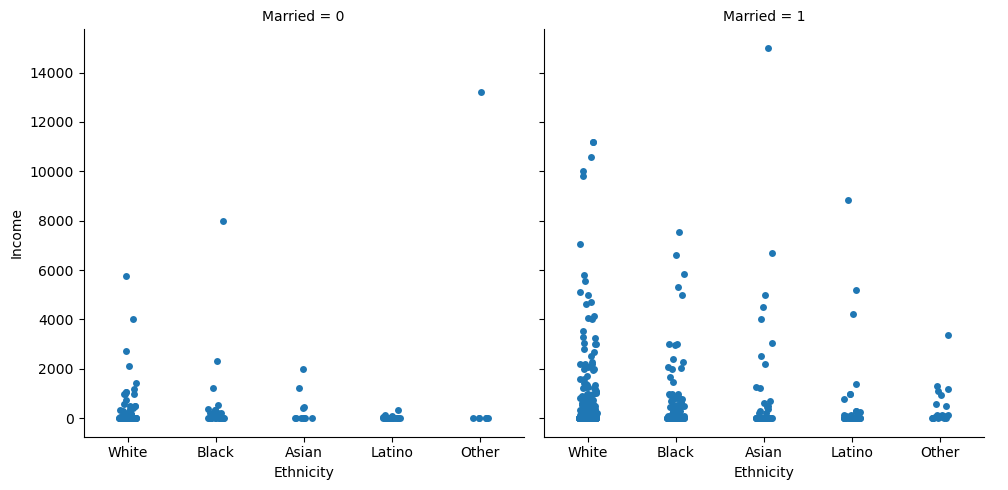

In [ ]:
sns.catplot(x=df["Ethnicity"], y=df["Income"], col=df["Married"])
plt.show()
print()

### Q1.8

Plot [barplot](https://seaborn.pydata.org/generated/seaborn.catplot.html), taking `Debt` for x-axis, `Industry` for y-axis and `Approved` as a hue. Make sure the axes are named. What are the industries with the highest average debt of people for approved (Approved=1) and rejected (Approved=0) credit applications?

*Answer format (example):* `Utilities,Energy`

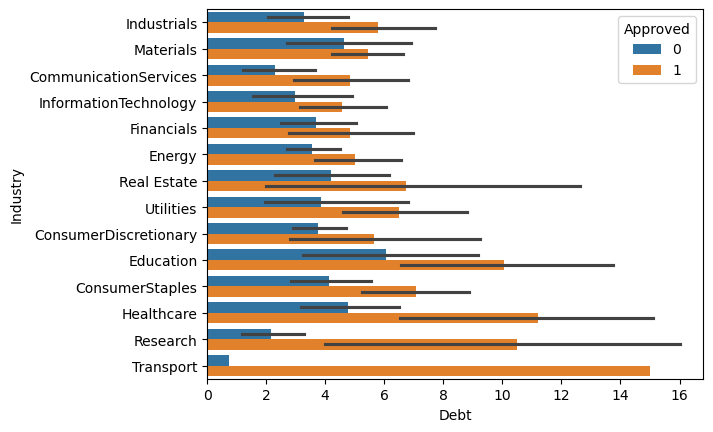

Transport,Education


In [11]:
sns.barplot(x=df["Debt"], y=df["Industry"],hue=df["Approved"])
plt.show()

approved = df[df["Approved"] == 1]
rejected = df[df["Approved"] == 0]
app_mean = approved.groupby("Industry")["Debt"].mean()
rej_mean = rejected.groupby("Industry")["Debt"].mean()
app_ind = app_mean.idxmax()
rej_ind = rej_mean.idxmax()
print(f"{app_ind},{rej_ind}")

### Q1.9

Create a [boxplot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html) showing the distribution of `YearsEmployed` across different industries. Name the axes. Which industry has the highest median years of employment? If there's a tie, choose the first one alphabetically.


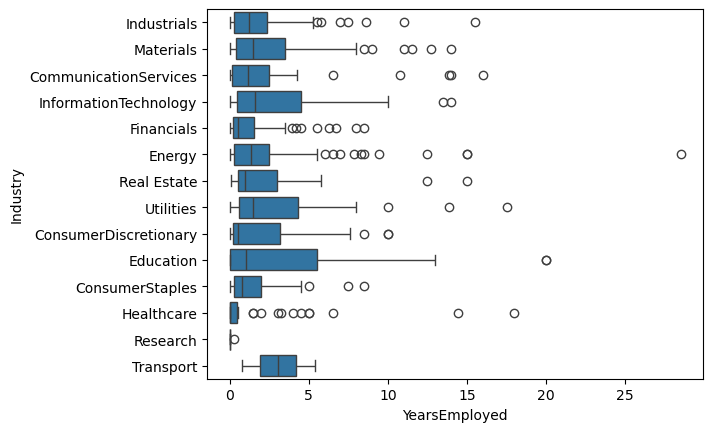

Transport


In [12]:
sns.boxplot(x=df["YearsEmployed"],y=df["Industry"])
plt.show()

print(df.groupby("Industry")["YearsEmployed"].median().idxmax())

### Q1.10

Create a heatmap showing the correlation matrix (`method=kendall`) between numerical features: `Age`, `Debt`, `InvestmentScore`, `YearsEmployed`, `CreditScore`, and `Income`. Which pair of features has the highest positive correlation?


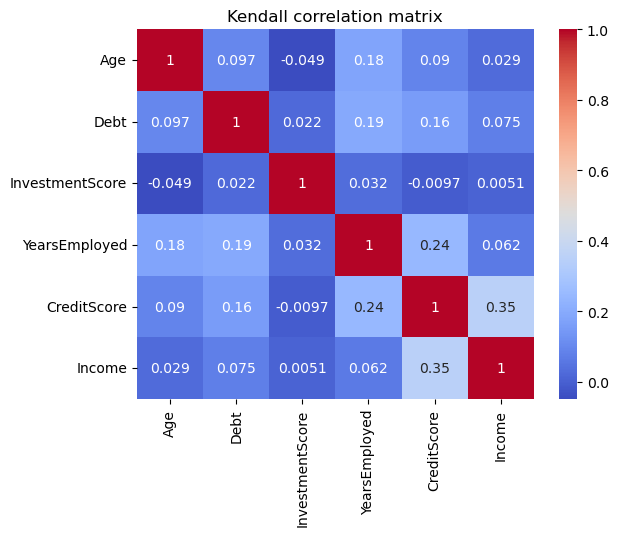

Income,CreditScore


In [13]:
df_filtered = df[["Age", "Debt", "InvestmentScore", "YearsEmployed", "CreditScore", "Income"]].corr(method="kendall")
sns.heatmap(df_filtered, annot=True,cmap="coolwarm")
plt.title("Kendall correlation matrix")
plt.show()

df_filtered = df_filtered.unstack()
df_filtered = df_filtered[df_filtered.index.get_level_values(0) != df_filtered.index.get_level_values(1)]
print(",".join(df_filtered.sort_values(ascending=False).idxmax()))


### Q1.11

Create a [violin plot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) showing the distribution of `Debt` for different ethnicities. Give it a title, name the axes. Which ethnicity has the highest median Debt?


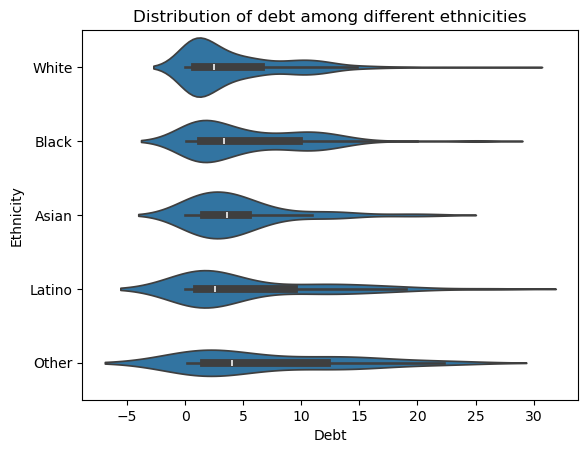

Other


In [14]:
sns.violinplot(x=df["Debt"], y=df["Ethnicity"])
plt.title("Distribution of debt among different ethnicities")
plt.show()

print(df.groupby("Ethnicity")["Debt"].median().idxmax())

### Q1.12

Create a [pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) for the features `Age`, `Income`, `Debt`. Use `Approved` as a hue. Based on that, conclude if such representation has predictive power relatively a credit approval. Write at least 4 sentences about different features and their pairs.

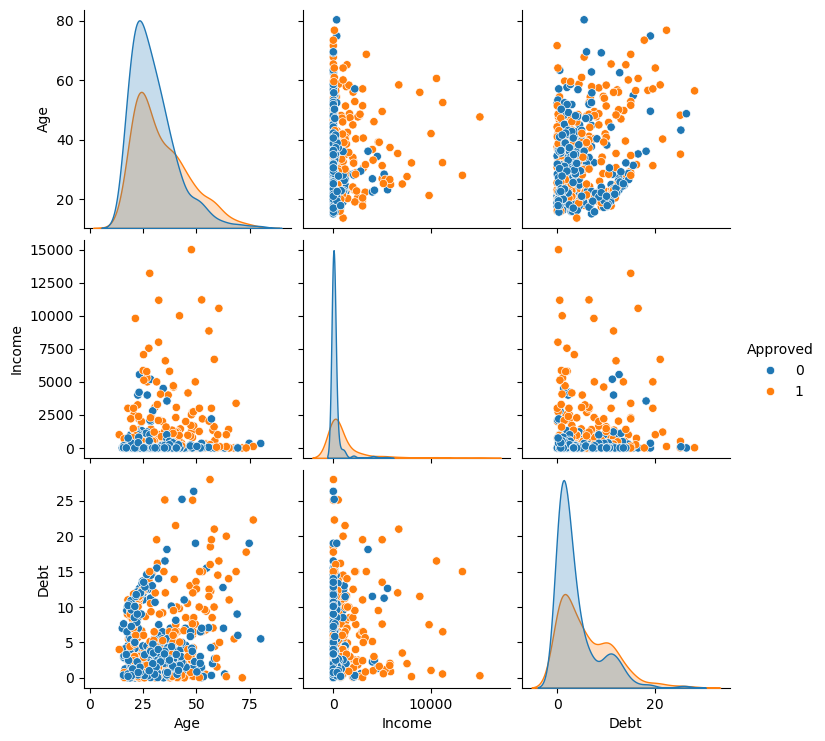

In [15]:
sns.pairplot(df, vars=["Age", "Income", "Debt"], hue="Approved")
plt.show()

1)According to correlation between age and debt columns: age affects status of approve because for the same debt more approvals for obtained by elder people

2)According to correlation between age and income columns: income affects the status too, because in most cases if you have more then average income you will be approved and doesn't matter is you old or young.

3)Same situation as in point 2. Income affects the status. Even if you have a big debt but also have a good income then you will be approved.

So in most cases this information can be relevant and used for next data processing and analysis.


## 2. Preprocessing
The goal of the segment is to prepare data for further work

Make sure you have dropped the values required by **Q1.6, Q2.1**

### Q2.1
There are two columns, that are exactly the same for all of the people. Let's drop one of them. As an answer, write the names of these columns divided by a comma without spaces and additional symbols.

Example for columns A, B: `A,B`

In [16]:
if (df["BankCustomer"] == df["BankRecord"]).all():
    print("BankCustomer,BankRecord")
df.drop("BankRecord", axis=1,inplace=True)

BankCustomer,BankRecord


### Q2.2

Now it's time to talk about the task for today. Our bank wants to predict whether the application for a loan is worthy or not. So we need to build a model that would predict it.

Let's divide the dataset into a target (the 'Approved' column) and data (the rest of the columns). What is the fraction of positive labels in the target (number of approved applications divided by the total number)?


In [17]:
target = df["Approved"]
data = df.iloc[:, :-1]
pos_approve = target.value_counts().loc[1]
ttl_approve = len(target)
print("{:.3f}".format(pos_approve/ttl_approve))

0.439


### Q2.3

To honestly estimate the performance of the model, we need to split the dataset into train and test parts. In reality, a test could be millions of customers and a train could be a small playground to estimate the campaign. Our current dataset is not that big, so let's say the test would be 40% of the dataset. Use `train_test_split` to make a split. Please set the `random_state` argument to 314 and **don't forget to shuffle and stratify by approval status**.
How many positive labels do you have in test targets?

In [18]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=314, shuffle=True, stratify=target)
pos_approve = y_test.value_counts().loc[1]
ttl_aprove = len(y_test)
print("{:.3f}".format(pos_approve/ttl_approve))

0.176


## 3. Basic (not tuned) models

Let's start with the most basic models. **In this section,** we going to use `logistic regression`, `k neighbors classifier`, and `random forest` **without param tuning**.

Some of the features are not usable in the current form as categorical, so let's make a copy of a dataset with the following columns for the section:

'Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'InvestmentScore', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'ZipCode', 'Income'

In [19]:
data_small = df[['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'InvestmentScore', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'ZipCode', 'Income']]

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(data_small, target, test_size=0.4, random_state=314,shuffle=True,stratify=target)

### Q3.1

Build a logistic regression model. Set max_iter parameter to 5000. What is the f1_score for the model on the test set?


In [20]:
lr_model = LogisticRegression(max_iter=5000)
lr_model.fit(x_train_new, y_train_new)

y_pred = lr_model.predict(x_test_new)
lr_result = f1_score(y_test_new, y_pred)
print(f"{lr_result:.3f}")

0.851


### Q3.2

Build a k-neighbors classifier with 5 neighbors. What is the f1_score for the model on the test set?

In [21]:
kn_model = KNeighborsClassifier(n_neighbors=5)
kn_model.fit(x_train_new,y_train_new)

y_pred = kn_model.predict(x_test_new)
kn_result = f1_score(y_test_new, y_pred)
print(f"{kn_result:.3f}")

0.580


### Q3.3

Build a random forest classifier with `n_estimators = 5` and `random_state=314`. What is the f1_score for the model on the test set?

In [22]:
rfs_model = RandomForestClassifier(n_estimators=5, random_state=314)
rfs_model.fit(x_train_new,y_train_new)

y_pred = rfs_model.predict(x_test_new)
rfs_result = f1_score(y_test_new, y_pred)
print(f"{rfs_result:.3f}")

0.810


### Q3.4

The models without fine-tuning are not as effective. First, let's try to regularize the regression above with the L2 norm. Use 5-split stratified cross-validation grid search to find the optimal C. You can use the verbose argument of GridSearchCV in order to watch the progress of cross-validation. What is the f1 score for the model on the test dataset with this regularization?

Use [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) with `shuffle=True` and `random_state=314`. Pass it to [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) with the same `random_state`. Choose `scoring='f1_macro'`.

Use `np.logspace(-5, 2, endpoint=True,  num=10)` for the parameter `C`.

*Hint*. Use GridSearch fit / predict methods.

In [23]:
c = np.logspace(-5, 2, endpoint=True, num=10)
param_dist = {'C': c}

skf = StratifiedKFold(shuffle=True, random_state=314,)
grid = RandomizedSearchCV(estimator=lr_model,random_state=314,scoring="f1_macro", param_distributions=param_dist, cv=skf)
grid.fit(x_train_new, y_train_new)

lr_model_new = LogisticRegression(**grid.best_params_)
lr_model_new.fit(x_train_new, y_train_new)
y_pred = lr_model_new.predict(x_test_new)
lr_result_new = f1_score(y_test_new, y_pred)

print(f"{lr_result_new:.3f}")

0.855


c:\Users\Phili\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Q3.5

Fine-tune a k-NN classifier, try to find an optimal number of neighbors, weights, and p with a 5-split cross-validation. What is the f1 score for a model on a test dataset with these parameters?

Use [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) with `shuffle=True` and `random_state=314`. Pass it to [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) with the same `random_state`. Choose `scoring='f1_macro'`.
Use `{'n_neighbors' : np.arange(1, 20), 'weights' : ['uniform', 'distance'], 'p':[1, 2, 3]}` for the grid of parameters.

In [24]:
param_dist = {
    'n_neighbors' : np.arange(1, 20), 
    'weights' : ['uniform', 'distance'], 
    'p':[1, 2, 3]
}

grid = RandomizedSearchCV(estimator=kn_model, random_state=314, scoring="f1_macro", param_distributions=param_dist, cv=skf)
grid.fit(x_train_new, y_train_new)

kn_model_new = KNeighborsClassifier(**grid.best_params_)
kn_model_new.fit(x_train_new, y_train_new)
y_pred = kn_model_new.predict(x_test_new)

kn_result_new = f1_score(y_test_new, y_pred)
print(f"{kn_result_new:.3f}")

0.645


### Q3.6

Use the 5-split CV to find the optimal number of estimators and max_features for the random forest. What is the f1 score for random forest on a test dataset with these parameters?

Use [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) with `shuffle=True` and `random_state=314`. Pass it to [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) with the same `random_state`. Choose `scoring='f1_macro'`.

Use `{'n_estimators' : np.arange(5, 110, 10), 'max_features': np.arange(1, 14)}` for the grid of parameters.

In [25]:
param_dist = {
    'n_estimators': np.arange(5, 110, 10),
    'max_features': np.arange(1, 14)
}

grid = RandomizedSearchCV(estimator=rfs_model, random_state=314, scoring="f1", param_distributions=param_dist, cv=skf)
grid.fit(x_train_new,y_train_new)

rfs_model_new = RandomForestClassifier(**grid.best_params_)
rfs_model_new.fit(x_train_new, y_train_new)
y_pred = rfs_model_new.predict(x_test_new)

rfs_result_new = f1_score(y_test_new, y_pred)
print(f"{rfs_result_new:.3f}")

0.856


### Q3.7
For each model, report an increase of the metric after the application of GridSearch in percents.
*Sample Answer:* 0.123,4.567,0.789

In [26]:
lr_ratio = (lr_result_new - lr_result) / lr_result * 100
kn_ratio = (kn_result_new - kn_result) / kn_result * 100
rfs_ratio = (rfs_result_new - rfs_result) / rfs_result * 100
print(f"{lr_ratio:.3f},{kn_ratio:.3f},{rfs_ratio:.3f}")

0.395,11.238,5.690


## 4. Working with features

Machine learning is sometimes called data science because everything depends on data. In this section, we'll apply some of the most popular modifications for data. IMPORTANT: In the previous section we took a subset of the columns; now it's time to work with all of them.

### Q4.1

We have three categorical columns - 'Industry', 'Ethnicity' and 'Citizen'. We can't use them directly with our models, so let's use one-hot encoding - create a separate binary column for each possible value and drop the original 'Industry', 'Ethnicity' and 'Citizen' columns.

Don't forget to delete initial categorical features. Use [get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) or [one hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). How many columns do we have now?

In [27]:
cat_cols = ["Industry", "Ethnicity", "Citizen"]

encoder = OneHotEncoder(handle_unknown="error", sparse_output=False)
encoder.fit(x_train[cat_cols])

encoded_train = encoder.transform(x_train[cat_cols])
encoded_test = encoder.transform(x_test[cat_cols])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(cat_cols), index=x_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(cat_cols), index=x_test.index)

x_train = pd.concat([x_train.drop(columns=cat_cols), encoded_train_df], axis=1)
x_test = pd.concat([x_test.drop(columns=cat_cols), encoded_test_df], axis=1)

print(len(x_train.columns) + 1) 

37


### Q4.2

One of the standard procedures is data standardizations - it strongly influences the results of k-NN and make the convergence of other algorithms (i.e. logreg and neural nets) much faster. Let's apply `StandardScaler` for all the numerical columns - 'Age', 'Debt', 'YearsEmployed', 'InvestmentScore', 'CreditScore', 'ZipCode', 'Income'. 

What is the maximum value of Income now in the test set?

In [28]:
num_cols = ['Age', 'Debt', 'YearsEmployed', 'InvestmentScore', 'CreditScore', 'ZipCode', 'Income']

scaler = StandardScaler()
scaler.fit(x_train[num_cols])

x_train[num_cols] = scaler.transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

print("{:.3f}".format(x_test["Income"].max()))

5.815


### Q4.3

To check the effects of the modification, train the logistic regression with **updated** optimal C. This means you have to run GridSearch one more time. What is the f1 score now? Use the same grid of parameters as before.

In [29]:
c = np.logspace(-5, 2, endpoint=True, num=10)
param_dist = {'C': c}

skf = StratifiedKFold(shuffle=True, random_state=314,)
grid = RandomizedSearchCV(estimator=lr_model,random_state=314,scoring="f1_macro", param_distributions=param_dist, cv=skf)
grid.fit(x_train, y_train)

lr_model_new_v2 = LogisticRegression(**grid.best_params_)
lr_model_new_v2.fit(x_train, y_train)
y_pred = lr_model_new_v2.predict(x_test)
lr_result_new = f1_score(y_test, y_pred)

print(f"{lr_result_new:.3f}")

1.000


### Q4.4

Do the same task as in **Q4.3** but for the following subset of features: 'Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'InvestmentScore', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'ZipCode', 'Income'. What is the f1 score now?

Save prediction labels and the probabilities of classes to a separate array (will be used in Q4.6).

In [30]:
target_cols = ['Gender', 'Age', 'Debt', 
               'Married', 'BankCustomer', 
               'InvestmentScore', 'YearsEmployed', 'PriorDefault', 
               'Employed', 'CreditScore', 'DriversLicense', 
               'ZipCode', 'Income']

x_train_small = x_train[target_cols]
x_test_small = x_test[target_cols]

c = np.logspace(-5, 2, endpoint=True, num=10)
param_dist = {'C': c}

skf = StratifiedKFold(shuffle=True, random_state=314,)
grid = RandomizedSearchCV(estimator=lr_model,random_state=314,scoring="f1_macro", param_distributions=param_dist, cv=skf)
grid.fit(x_train_small, y_train)

lr_model_new_sub = LogisticRegression(**grid.best_params_)
lr_model_new_sub.fit(x_train_small, y_train)
y_pred_lr = lr_model_new_sub.predict(x_test_small)
y_prob_lr = lr_model_new_sub.predict_proba(x_test_small)
lr_result_new = f1_score(y_test, y_pred_lr)

print(f"{lr_result_new:.3f}")

0.851


### Q4.5

Train a k-NN with **updated** optimal params. Use the same set of features as in Q4.3. What is the f1 score now?
Save prediction labels and the probabilities of classes to a separate array (will be used in Q4.6).

In [31]:
param_dist = {
    'n_neighbors' : np.arange(1, 20), 
    'weights' : ['uniform', 'distance'], 
    'p':[1, 2, 3]
}

grid = RandomizedSearchCV(estimator=kn_model, random_state=314, scoring="f1_macro", param_distributions=param_dist, cv=skf)
grid.fit(x_train, y_train)

kn_model_new_v2 = KNeighborsClassifier(**grid.best_params_)
kn_model_new_v2.fit(x_train, y_train)
y_pred_kn = kn_model_new_v2.predict(x_test)
y_prob_kn = kn_model_new_v2.predict_proba(x_test)

kn_result_new = f1_score(y_test, y_pred_kn)
print(f"{kn_result_new:.3f}")

0.936


### Q4.6

Another popular performance metric is the ROC curve. Build a roc-curve for logistic regression and KNN from Q4.4, Q4.5 on the sample plot. How much do their TPRs differ when FPR=0.3? *(approximately, up to the number of the form $0.025k, k \in \mathbb Z$)*?

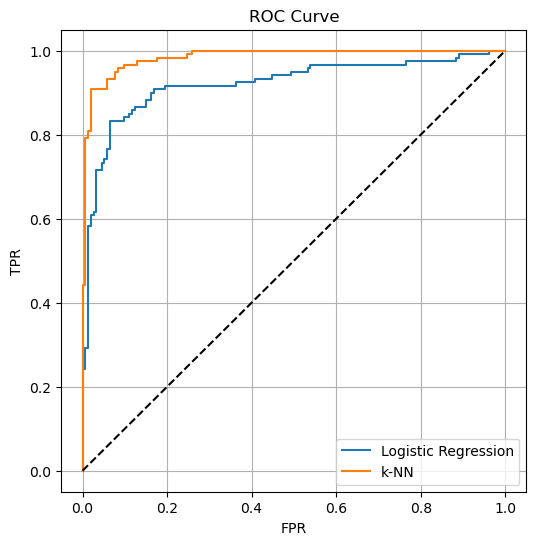

0.083


In [32]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob_lr[:,1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_kn[:,1])

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
plt.plot(fpr_knn, tpr_knn, label="k-NN")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

fpr_target = 0.3
tpr_lr_03 = np.interp(fpr_target, fpr_lr, tpr_lr)
tpr_knn_03 = np.interp(fpr_target, fpr_knn, tpr_knn)

print("{:.3f}".format(abs(tpr_knn_03-tpr_lr_03)))

### Q5.1

Analyze the results from Q4.3 - Q4.6.

- Does our preprocessing improve the metric for logistic regression? Why?
- Does our preprocessing improve the metric for KNN? Why?
- Is such preprocessing compulsory for Random Forest?
- Which model is better in terms of ROC-AUC score, Logistic Regression or KNN?

1) In my case scaling didn't really affect the result in case of logistic regression. Even simple gridsearch without scaler did better. This can be due to all numeric features are already good scaled or because of solver lbfgs which can handle only moderate differences (the same problem comes in Q3.4 with warning). In other side encoder gave me a result "1.0" which means perfect prediction. If we hope that everything is done well, so it may be cuased by “ease” of data or perfect separation along these categorical features
   
2) For KNN it's strongly improves the result, from KNN 0.580 up to 0.936. So knn is a distance-based algorithm and the distance metric is heavily affected by feature scales. That's why scaling helps to reduce dominance of large magnitudes in distance calculation. Also representation of categorical features as some numerics which can also be estimated improves the result
   
3) In Random Forest spliting the data based on thresholds in feature values and is scale-invariant. Trees automatically handle numeric features in their original scale, so standardization or normalization is not required here. But for one-hot encoding categorical variables is optional for Random Forest depending on importance and value of these features

4) In my case KNN was better because it shows better true positive rate for the same fpr(goes higher than logistic regression)

### Q5.2

Propose two derivative features and retrain one of the models with them.
- What is the performance?
- Justify your choice of these features in terms of banking and finance.

1) Debt to income ration - because it's a key value in taking decision for all new loans. In machine learning difference between debt and income numbers for this purpose can be not so understandable
   
2) Employment stability - shows the proportion of a person’s life spent employed. More stable employment often correlates with higher creditworthiness

3) Resulting perfomance even with using scaled and encoded data became better 0.911 vs 0.851. Testing for knn showed worse results, in base case it means that additional features helps logistic regressor to find non-linear dependances better while for knn it reduce it's power.

In [33]:
x_train['DebtToIncome'] = df['Debt'] / (df['Income'] + 1e-6)
x_train['EmploymentStability'] = df['YearsEmployed'] / (df['Age'] + 1e-6)

x_test['DebtToIncome'] = x_test['Debt'] / (x_test['Income'] + 1e-6)
x_test['EmploymentStability'] = x_test['YearsEmployed'] / (x_test['Age'] + 1e-6)

c = np.logspace(-5, 2, endpoint=True, num=10)
param_dist = {'C': c}

skf = StratifiedKFold(shuffle=True, random_state=314,)
grid = RandomizedSearchCV(estimator=lr_model,random_state=314,scoring="f1_macro", param_distributions=param_dist, cv=skf)
grid.fit(x_train, y_train)

lr_model_new_v3 = LogisticRegression(**grid.best_params_)
lr_model_new_v3.fit(x_train, y_train)
y_pred = lr_model_new_v3.predict(x_test)
lr_result_new = f1_score(y_test, y_pred)

print(f"{lr_result_new:.3f}")

0.941


c:\Users\Phili\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Q5.3

Train an xboost model with test f1 score 0.85+

In [34]:
from xgboost import XGBClassifier

df['DebtToIncome'] = df['Debt'] / (df['Income'] + 1e-6)
df['EmploymentStability'] = df['YearsEmployed'] / (df['Age'] + 1e-6)

target = df["Approved"]
data = df.drop('Approved', axis=1)

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)

x_train = x_train.fillna(0)
x_test = x_test.fillna(0)


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train[cat_cols]), index=x_train.index)
x_test_ohe  = pd.DataFrame(ohe.transform(x_test[cat_cols]), index=x_test.index)

x_train_num = x_train.drop(cat_cols, axis=1)
x_test_num  = x_test.drop(cat_cols, axis=1)

x_train_final = pd.concat([x_train_num, x_train_ohe], axis=1)
x_test_final  = pd.concat([x_test_num, x_test_ohe], axis=1)

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(x_train_final, y_train)

y_pred = xgb_model.predict(x_test_final)
xgb_result = f1_score(y_test, y_pred)
print(f"{xgb_result:.3f}")



0.894
